In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib.ticker import FormatStrFormatter

from sklearn.manifold import TSNE

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Loading the data

We can load the data stored in the cached pickle files available from the earlier steps. The only difference is we will ignore the tissue type values from the last column of the "all_data_final.pkl" file and load list of ages from a separate pickle.

We will also make sure to remove any samples for which age is not a numeric value (some of the rows contain a string "'--" instead).

In [8]:
def load_data():
    # load TCGA data from pickle file
    all_ages_file_path = "all_ages.pkl"
    all_data_file_path = "all_data_final.pkl"

    with open(all_ages_file_path, 'rb') as f:
        age = pickle.load(f)

    with open(all_data_file_path, 'rb') as f:
        data = pickle.load(f)

    print(age)
    
    # some age values are missing (they are '--)
    # we will drop them

    print(f"Number of samples BEFORE cleaning the samples with invalid age: {age.shape[0]}")
    float_idx = age[age.columns[0]].map(lambda x: x.isdigit()).values
    age = pd.DataFrame(age.loc[float_idx, :]).astype('float32')
    data_valid_age = data.loc[float_idx, :]
    data_valid_age = data_valid_age.iloc[:, :-1]
    del data

    print(f"Number of samples AFTER cleaning the samples with invalid age: {age.shape[0]}")

    return (data_valid_age, age)

In [3]:
data_valid_age, age = load_data()
age

Number of samples BEFORE cleaning the samples with invalid age: 8668
Number of samples AFTER cleaning the samples with invalid age: 6647


,0
1,67.0
2,78.0
3,64.0
4,74.0
7,62.0
...,...
8662,39.0
8663,86.0
8664,77.0
8666,35.0


We can see that our data cleaning procedure removed 8668 - 6647 = 2021 samples, which is almost 23% of our initial sample count. 

Let's plot the distribution of age values to make sure nothing is wrong.

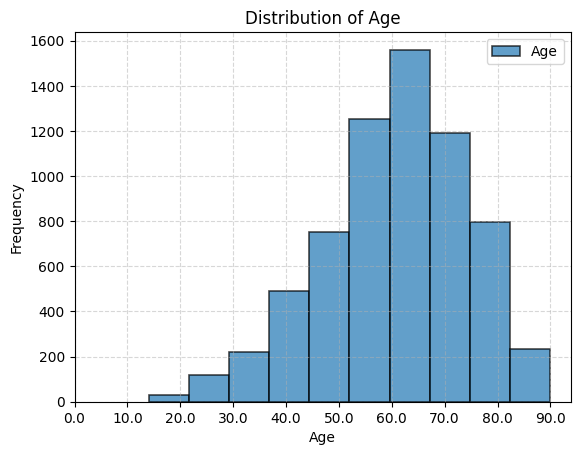

In [4]:
# Create the plot
plt.hist(age, bins=10, edgecolor='black', linewidth=1.2, alpha=0.7, label='Age')

# Set plot aesthetics
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.legend()

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust x-axis tick labels
tick_values = np.arange(0, max(age[0])+1, 10)
plt.xticks(tick_values, [str(val) for val in tick_values])

# Show the plot
plt.show()


# t-SNE

In [5]:
# Perform t-SNE analysis
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(data_valid_age)

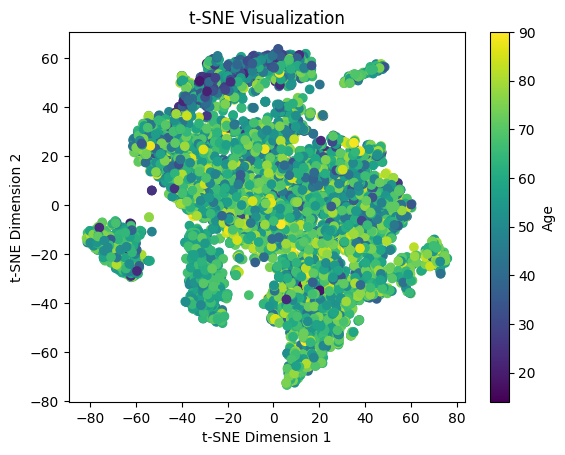

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(features_tsne[:, 0], features_tsne[:, 1], c=age, cmap="viridis")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_title("t-SNE Visualization")
plt.colorbar(scatter, ax=ax, label="Age")
plt.show()
del tsne
del features_tsne


We can see some clustering, but nothing too conclusive.

# Training the age prediction model

We will first try without augmentation, with just 6647 filtered samples. No feature selection, no data augmentation.

The ocde for training the model the (input, output) data pair is extracted into the function train_age_prediction(age_input, age_output) because it needs to be invoked multiple times, so it is reusable. Same with the function to plot error distributions.

In [5]:
def train_age_prediction(age_input, age_output): 

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(age_input, age_output, test_size=0.2, random_state=42)

    # Train an XGBoost regression model
    print("Training the model...")
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    del y_pred
    del X_train, X_test, y_train, y_test

    return (model, mse)

def plot_charts(model, age_input, age_output):
    ### plot error distribution charts ###

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(age_input, age_output, test_size=0.2, random_state=42)

    predictions = model.predict(X_test)

    results = pd.DataFrame({'Actual': y_test[0], 'Predicted': predictions})
    errors = results['Actual'] - results['Predicted']
    predictions_train = model.predict(X_train)
    results_train = pd.DataFrame({'Actual': y_train[0], 'Predicted': predictions_train})
    errors_train = results_train['Actual'] - results_train['Predicted']
    # Determine the common range for both histograms
    min_error = min(errors.min(), errors_train.min())
    max_error = max(errors.max(), errors_train.max())
    # Plot the histograms
    plt.hist(errors, bins=40, alpha=0.5, range=(min_error, max_error), label='Test Errors', density=True)
    plt.hist(errors_train, bins=40, alpha=0.5, range=(min_error, max_error), label='Train Errors', density=True)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Comparison of Test and Train Errors')
    plt.legend()
    plt.show()

    plt.style.use('seaborn-whitegrid')
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    # Plot distribution of train errors
    axes[0].hist(errors_train, color='orange', alpha=0.7)
    axes[0].set_xlabel('Error')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Train Error Distribution')
    # Plot distribution of errors
    axes[1].hist(errors, color='blue', alpha=0.7)
    axes[1].set_xlabel('Error')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Test Error Distribution')
    plt.subplots_adjust(wspace=0.4)
    fig.tight_layout()
    plt.show()

    del predictions
    del results
    del errors
    del results_train
    del errors_train
    del X_train, X_test, y_train, y_test


In [10]:
print("Training the model without augmentation.")
model_no_aug, mse_no_aug = train_age_prediction(data_valid_age, age)

Training the model without augmentation.
Training the model...
Mean Squared Error: 139.04783630371094


# No augmentation, no feature selection -> MSE = 139.04

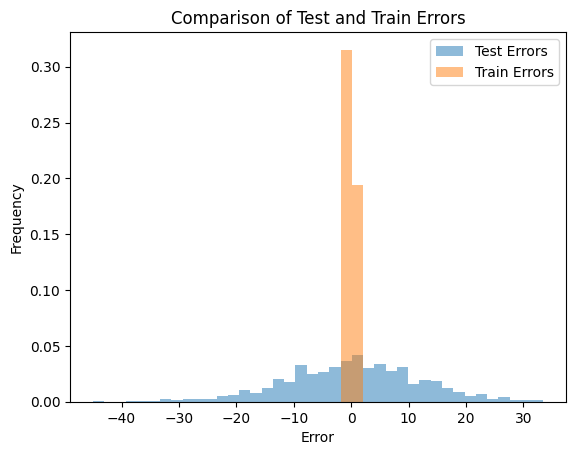

/tmp/ipykernel_971399/1859522375.py:48: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


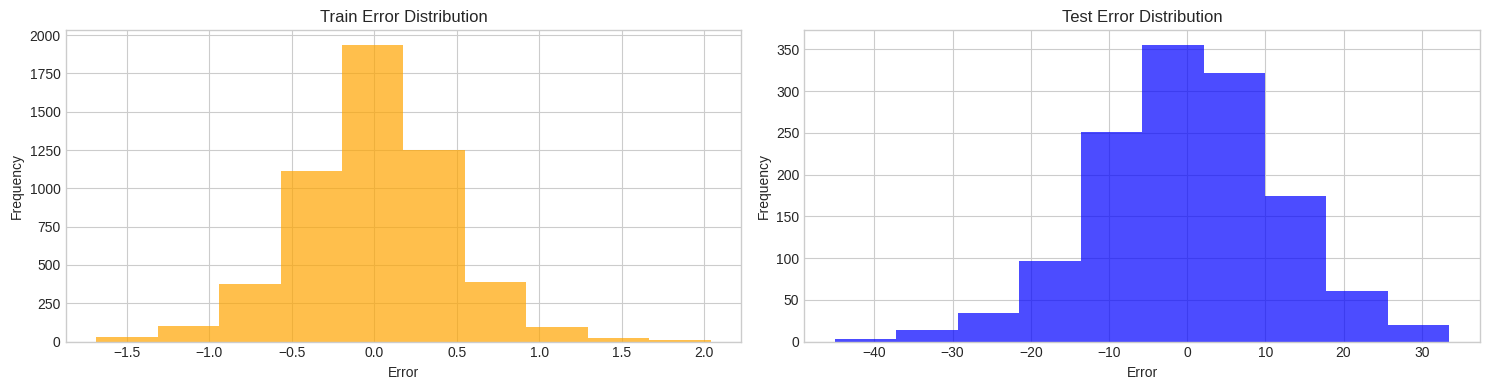

In [11]:
plot_charts(model_no_aug, data_valid_age, age)

# Adding augmentation

In [6]:
# random drop data augmentation
# we will drop 10% of the data
# this is to prevent overfitting
# and to make the model more robust
data_valid_age_aug = data_valid_age.copy()
mask = pd.DataFrame(np.random.rand(*data_valid_age_aug.shape)) < 0.2
data_valid_age_aug[mask] = 0

print(f"Data before augmentation: {data_valid_age.shape}")
final_data = pd.concat([data_valid_age_aug, data_valid_age])
final_age = pd.concat([age, age])
print(f"Data after augmentation: {final_data.shape}")

del data_valid_age
del age
del mask

print("Training the model ")
model_aug_20, mse_aug_20 = train_age_prediction(final_data, final_age)

Data before augmentation: (6647, 59427)
Data after augmentation: (13294, 59427)
Training the model 
Training the model...
Mean Squared Error: 26.012821197509766


# 20% augmentation, no feature selection -> MSE = 26.01

        0
0     '--
1      67
2      78
3      64
4      74
...   ...
8663   86
8664   77
8665  '--
8666   35
8667   47

[8668 rows x 1 columns]
Number of samples BEFORE cleaning the samples with invalid age: 8668
Number of samples AFTER cleaning the samples with invalid age: 6647


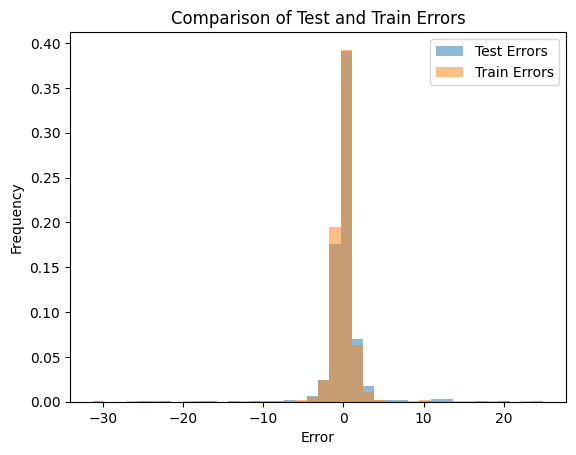

/tmp/ipykernel_997695/1859522375.py:48: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


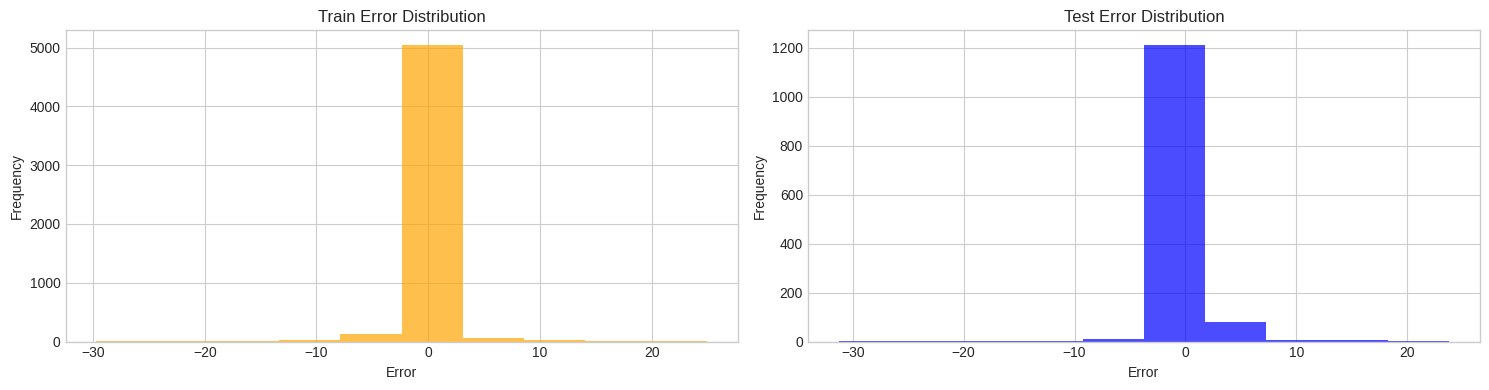

In [11]:
del final_data
del final_age
data_valid_age, age = load_data()
plot_charts(model_aug_20, data_valid_age, age)

We can conclude that 20% of data augmentation had a monumental effect on the accuracy, reducing the MSE from 139.04 to staggering 26.01!

# Feature selection only

In [18]:
# perform feature selection
K = 7000

test = SelectKBest(score_func=f_regression, k=K)
features = test.fit_transform(data_valid_age, age)

model_feature_selection, mse_feature_selection = train_age_prediction(features, age)

/home/rubi/RNA-seq-cancer-detector/RNA-seq-cancer-classification/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training the model...
Mean Squared Error: 147.01861572265625


# No augmentation, feature selection K = 2000 -> MSE = 151.22

We have tested feature selection for various values of K and we are showing it on a comparison plot together with the other data preparation techniques.

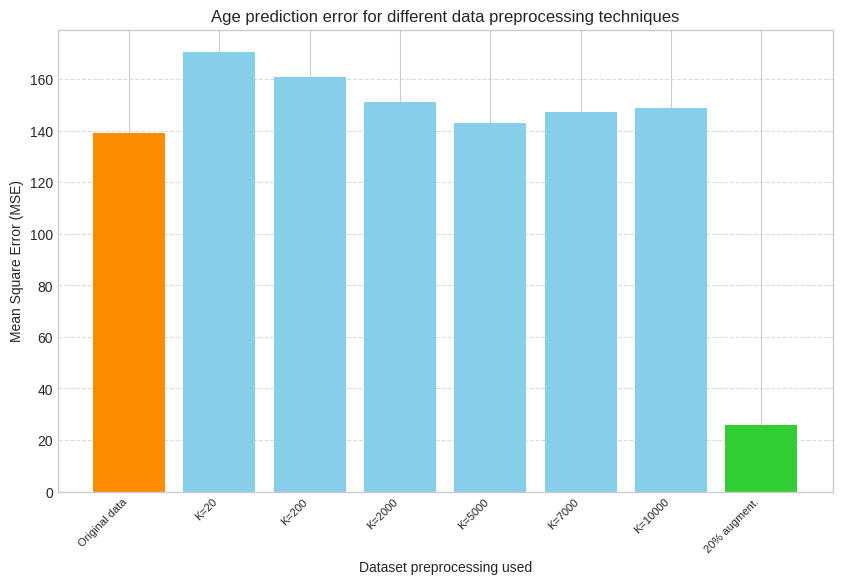

In [24]:
feature_selection_mse = {
    "Original data": 139.04, 
    "K=20": 170.62,
    "K=200": 160.95,
    "K=2000": 151.22,
    "K=5000": 143.08,
    "K=7000": 147.01,
    "K=10000": 148.89,
    "20% augment.": 26.01
}
# Extract the labels and values
labels = list(feature_selection_mse.keys())
values = list(feature_selection_mse.values())

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as desired

# Custom colors for the first and last columns
colors = ['darkorange'] + ['skyblue'] * (len(labels) - 2) + ['limegreen']

# Creating the bar plot
plt.bar(labels, values, color=colors)

plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate x-axis labels for better readability
plt.xlabel('Dataset preprocessing used')
plt.ylabel('Mean Square Error (MSE)')
plt.title('Age prediction error for different data preprocessing techniques')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding horizontal grid lines

# Display the plot
plt.show()

# Conclusion

The results seem to be reassuring - pure feature selection seems to slightly degrade the performance of the model to generalize to unseen data. 

What seems to helps a lot is data augmentation, it is driving down the MSE almost 5x, which is a very good result.